In [1]:
import ensembles as es
import matplotlib.pyplot as plt
import jax.random as jr
from jax.config import config
import seaborn as sns
from glob import glob 
import numpy as np
import xarray as xr
import copy
from tqdm import tqdm

config.update("jax_enable_x64", True)
key = jr.PRNGKey(123)
sns.set_style('whitegrid')

%load_ext autoreload
%autoreload 2

%matplotlib inline

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
2022-06-14 15:02:45.375676: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Read

### Obs

Using 20 observational realisations


/home/pindert2/bayesian_ensembling/ensembles/data.py:242: UserWarning: Collapsing (mean) non-time dimensions for plotting
  warnings.warn('Collapsing (mean) non-time dimensions for plotting')


<AxesSubplot:title={'center':'Observations'}>

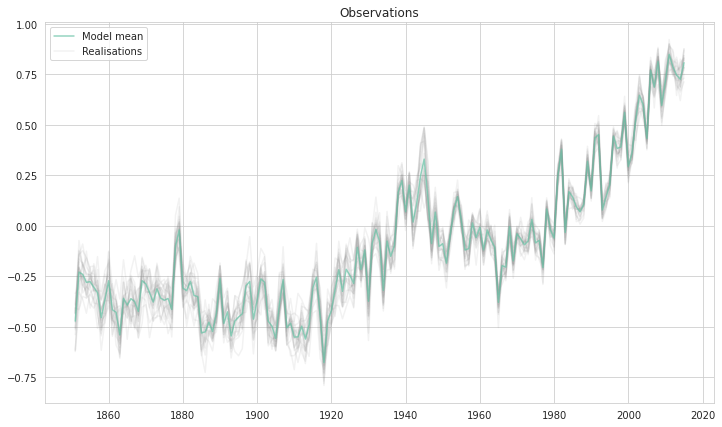

In [2]:
n_obs_realisations = 20
obs_da = xr.open_mfdataset(glob('data/obs/gridded/Had*.nc'), combine='nested', concat_dim='realization').tas[:n_obs_realisations].load()
obs_da = obs_da.rename(realization='realisation')
obs_da = obs_da.sel(time=slice('1850-01-01', '2014-12-31'))
obs_time = obs_da.time
obs_da = obs_da.resample(time='Y').mean()
observations = es.ProcessModel(obs_da, model_name='Observations')
print(f'Using {n_obs_realisations} observational realisations')
observations.plot()

## Models

Currently subsetting the ssp models in time to make the barycentre computation tolerable

In [3]:
def prepro(ds):
    model_real = ds.encoding['source'].split('_')[-1][:-3]
    ds = ds.assign_coords(realisation=model_real)
    if 'height' in ds.coords:
        ds = ds.drop('height')
    return ds

In [4]:
# TODO: Do a thorough assessment of physics, and forcing realisations to use
hist_model_files = glob('data/gridded/historical/*.nc')
ssp_model_files = glob('data/gridded/ssp245/*.nc')

hist_model_names = np.unique(['_'.join(file.split('/')[-1].split('_')[:2]) for file in hist_model_files])
ssp_model_names = np.unique(['_'.join(file.split('/')[-1].split('_')[:2]) for file in ssp_model_files])

unique_models = np.intersect1d(hist_model_names, ssp_model_names)

# Load hist
hist_anom_models = []
climatology_dict = dict()
for model_name in tqdm(unique_models):
    model_files = [file for file in hist_model_files if model_name + '_' in file]
    # The + '_' is to stop CanESM5-OE being pulled into CanESM5
    # Here we remove the p1 - misspecified land fraction over antarctica
    if model_name == 'CCCma_CanESM5':
        files_to_remove = [file for file in model_files if 'p1' in file]
        [model_files.remove(file) for file in files_to_remove]
    # Here we ignore the differences in the forcings (f1=AMIP, f2=AMIP + Hetr. O3 corr., f3=GISS-E2-2 comp. forcings)
    # Here we remove p1 and p5 physics schemes as these aren't in the SSPs, only p3 (One-Moment Aerosol (OMA)) is kept
    # TODO: Want to check the logic in removing these
    # Remove f2 forcing as there is only 1 ssp245 realisation - check for ssp370
    if model_name == 'NASA-GISS_GISS-E2-1-G':
        files_to_remove = [file for file in model_files if 'f2' in file]
        files_to_remove += [file for file in model_files if 'p1' in file]
        files_to_remove += [file for file in model_files if 'p5' in file]
        [model_files.remove(file) for file in np.unique(files_to_remove)]
    da = xr.open_mfdataset(model_files, preprocess=prepro, combine='nested', concat_dim='realisation').tas.load()
    da['time'] = obs_time # Replace time with observational time to avoid later problems
    model_data = es.ProcessModel(da, model_name)

    # Find the anomally of that data
    anomaly_model = model_data.calculate_anomaly(resample_freq='Y')
    hist_anom_models.append(anomaly_model)
    climatology_dict[model_name] = anomaly_model.climatology

# Load ssp
ssp_anom_models = []
for model_name in tqdm(unique_models):
    model_files = [file for file in ssp_model_files if model_name + '_' in file]
    # The + '_' is to stop CanESM5-OE being pulled into CanESM5
    # Here we remove the p1 - misspecified land fraction over antarctica
    if model_name == 'CCCma_CanESM5':
        files_to_remove = [file for file in model_files if 'p1' in file]
        [model_files.remove(file) for file in files_to_remove]
    # Remove f2 forcing as there is only 1 ssp245 realisation - check for ssp370
    if model_name == 'NASA-GISS_GISS-E2-1-G':
        files_to_remove = [file for file in model_files if 'f2' in file]
        [model_files.remove(file) for file in files_to_remove]
    da = xr.open_mfdataset(model_files, preprocess=prepro, combine='nested', concat_dim='realisation').tas.load()[:, :24]
    # Convert time out of cftime to help matplotlib
    try:
        datetimeindex = da.indexes['time'].to_datetimeindex()
        da['time'] = datetimeindex
    except AttributeError:
        pass
    model_data = es.ProcessModel(da, model_name)

    # Find the anomally of that data
    anomaly_model = model_data.calculate_anomaly(resample_freq='Y', climatology=climatology_dict[model_name])
    ssp_anom_models.append(anomaly_model)

hist_anom_models = es.ModelCollection(hist_anom_models)
ssp_anom_models = es.ModelCollection(ssp_anom_models)


  0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_12704/241032214.py:54: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = da.indexes['time'].to_datetimeindex()
 67%|██████▋   | 2/3 [00:00<00:00,  7.53it/s]/tmp/ipykernel_12704/241032214.py:54: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, '360_day', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = da.indexes['time'].to_datetimeindex()
100%|██████████| 3/3 [00:00<00:00,  6.94it/s]


/home/pindert2/bayesian_ensembling/ensembles/data.py:469: UserWarning: Collapsing (mean) non-time dimensions for plotting
  warnings.warn('Collapsing (mean) non-time dimensions for plotting')
/home/pindert2/bayesian_ensembling/ensembles/data.py:469: UserWarning: Collapsing (mean) non-time dimensions for plotting
  warnings.warn('Collapsing (mean) non-time dimensions for plotting')
/home/pindert2/bayesian_ensembling/ensembles/data.py:469: UserWarning: Collapsing (mean) non-time dimensions for plotting
  warnings.warn('Collapsing (mean) non-time dimensions for plotting')


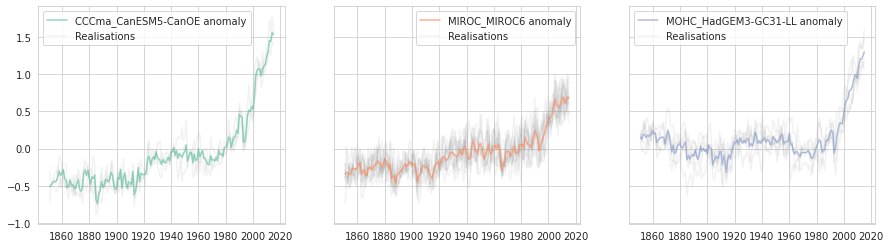

In [5]:
hist_anom_models.plot_grid()

/home/pindert2/bayesian_ensembling/ensembles/data.py:439: UserWarning: Collapsing (mean) non-time dimensions for plotting
  warnings.warn('Collapsing (mean) non-time dimensions for plotting')
/home/pindert2/bayesian_ensembling/ensembles/data.py:439: UserWarning: Collapsing (mean) non-time dimensions for plotting
  warnings.warn('Collapsing (mean) non-time dimensions for plotting')
/home/pindert2/bayesian_ensembling/ensembles/data.py:439: UserWarning: Collapsing (mean) non-time dimensions for plotting
  warnings.warn('Collapsing (mean) non-time dimensions for plotting')


<AxesSubplot:>

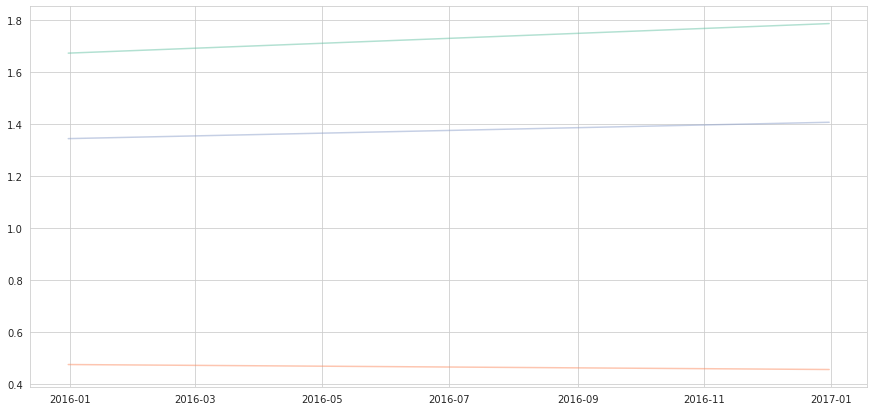

In [6]:
ssp_anom_models.plot_all()

Fit the process models using either mean field approximation or GPDTW

In [7]:
# hist_anom_models.fit(model=es.GPDTW(), compile_objective=True)
hist_anom_models.fit(model=es.MeanFieldApproximation(), compile_objective=True)

/home/pindert2/bayesian_ensembling/ensembles/models.py:101: UserWarning: No optimiser specified, using Adam with learning rate 0.01
  warnings.warn("No optimiser specified, using Adam with learning rate 0.01")
Objective:  1140669.00: 100%|██████████| 500/500 [00:09<00:00, 53.91it/s]


Weight models

In [8]:
ll_weight_function = es.LogLikelihoodWeight()
ll_weights = ll_weight_function(hist_anom_models, observations)

uniform_weight_function = es.UniformWeight()
uniform_weights = uniform_weight_function(hist_anom_models, observations)

weighted_weight_function = es.InverseSquareWeight()
weighted_weights = weighted_weight_function(hist_anom_models, observations)

100%|██████████| 19/19 [00:00<00:00, 427.68it/s]


/tmp/ipykernel_12704/701241410.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  p1 = axes[0].pcolormesh(ll_weights.latitude, ll_weights.model, ll_weights.mean(['time', 'longitude']).values, vmin=vmin, vmax=vmax)
/tmp/ipykernel_12704/701241410.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  p2 = axes[1].pcolormesh(ll_weights.latitude, ll_weights.model, weighted_weights.mean(['time', 'longitude']).values, vmin=vmin, vmax=vmax)
/tmp/ipykernel_12704/70124

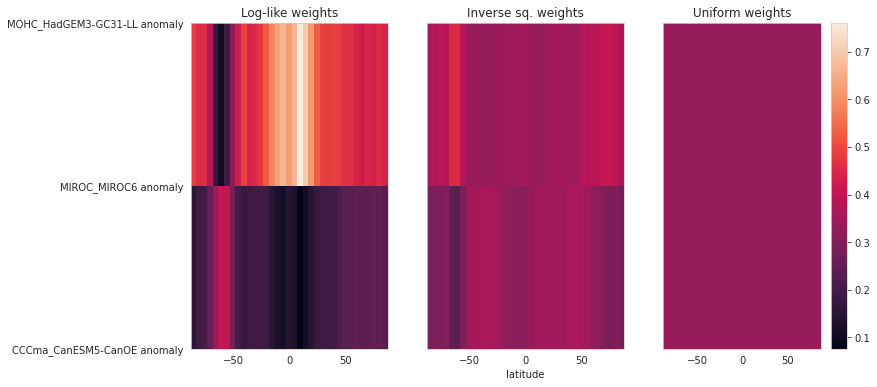

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 6))
vmax = np.max([ll_weights.mean(['time', 'longitude']), weighted_weights.mean(['time', 'longitude'])])
vmin = np.min([ll_weights.mean(['time', 'longitude']), weighted_weights.mean(['time', 'longitude'])])

p1 = axes[0].pcolormesh(ll_weights.latitude, ll_weights.model, ll_weights.mean(['time', 'longitude']).values, vmin=vmin, vmax=vmax)
plt.colorbar(p1)
axes[0].set_title('Log-like weights')
p2 = axes[1].pcolormesh(ll_weights.latitude, ll_weights.model, weighted_weights.mean(['time', 'longitude']).values, vmin=vmin, vmax=vmax)
axes[1].set_title('Inverse sq. weights')
p3 = axes[2].pcolormesh(ll_weights.latitude, ll_weights.model, uniform_weights.mean(['time', 'longitude']).values, vmin=vmin, vmax=vmax)
axes[2].set_title('Uniform weights')
axes[1].set_xlabel('latitude')
plt.show()

Construct the barycentre

In [10]:
ssp_anom_models.fit(model=es.MeanFieldApproximation(), compile_objective=True)

/home/pindert2/bayesian_ensembling/ensembles/models.py:101: UserWarning: No optimiser specified, using Adam with learning rate 0.01
  warnings.warn("No optimiser specified, using Adam with learning rate 0.01")
Objective:  13135.06: 100%|██████████| 500/500 [00:01<00:00, 275.88it/s]


Average weights in time and them ensure that there is a weight per space and time

In [11]:
single_ll_weights = ll_weights.mean('time').expand_dims(time=ssp_anom_models[0].model_data.time, axis=1)

This parallelisation is hilariously temperamental... Sometimes its 600 it/s. Sometimes being the key word

In [12]:
import jax.numpy as jnp

jnp.stack([ssp_anom_models.models[0].distribution._dist.stddev()]*2).shape

(2, 5184)

/home/pindert2/bayesian_ensembling/ensembles/data.py:64: UserWarning: Collapsing (mean) temporal dimensions for plotting
  warnings.warn('Collapsing (mean) temporal dimensions for plotting')


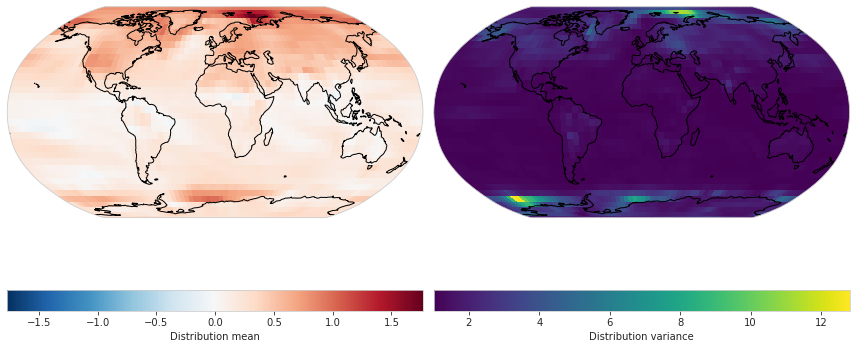

In [17]:
ensemble_method = es.Barycentre()
weighted_barycentre = ensemble_method(ssp_anom_models, single_ll_weights, n_threads=6)

weighted_barycentre.plot_spatially()

### Construct different ensemble outputs

In [15]:
weighted_mean = es.WeightedModelMean()(hist_anom_models, weights=weighted_weights)
multi_model_mean = es.MultiModelMean()(hist_anom_models, weights=None)